# AKPIK Datathon 2023

Welcome to our Datathon! This Jupyter notebook loads the data for you and takes out a prior evaluation of your solutions. You can also study the data and build your solutions inside this notebook.

**The data** consists of tiny grayscale images (28x28 pixels), which need to be classified into 10 classes. Below, we will take a look at some of these images.

**Your goal** is to find those 10k training examples, from which the best classifier can be trained. The classifier is a fixed 3-layer neural network that is already implemented below. You are given a large pool of training data to select your 10k examples from. You are also given the features of the test set, but not the corresponding labels! Can you figure out the best training examples?

## Basics: data loading and evaluation

The following code implements our evaluation and downloads the data.

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime, timezone

def evaluate(X_trn, y_trn, X_val, y_val, n_trials=10):
    """
    Evaluate the fixed model with given training and validation sets.
    
    The final evaluation pipeline of the Datathon is based on precisely the same function,
    but employs the testing data (X_tst, y_tst), of which the true labels y_tst remain
    undisclosed to you.
    """
    print("Evaluating the model...")
    performances = np.zeros(n_trials)
    for i in range(n_trials): # evaluate the training procedure 10 times
        model = tf.keras.Sequential([ # we use a simple, fully-connected, 3-layer neural network
            tf.keras.layers.Flatten(input_shape=(28, 28)), # inputs have 28x28 pixels
            tf.keras.layers.Dense(256, activation="relu"), # ReLU activation with 256 hidden units
            tf.keras.layers.Dense(10) # the output are 10 class probabilities
        ])
        model.compile( # we will optimize for accuracy, using the standard ADAM optimizer
            optimizer = "adam",
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics = ["accuracy"]
        )
        model.fit(X_trn, y_trn, epochs=10, validation_split=.1, verbose=0) # train the neural network
        performances[i] = model.evaluate(X_val, y_val, verbose=0)[1] # evaluate the neural network
        print(f"Testing accuracy [{i+1:02d}/{len(performances)}]: {performances[i]:.4f}")
    print("Average accuracy:", np.mean(performances), "+-", np.std(performances))

def download_data():
    """
    Download the training features, the training labels, and the testing features.
    """
    import os
    import urllib.request
    for data_path in ["X_trn.npy", "y_trn.npy", "X_tst.npy"]:
        if not os.path.isfile(data_path):
            url = "https://tu-dortmund.sciebo.de/s/7Bespy29gx955hQ/download?files=" + data_path
            print(f"Downloading {data_path} from {url}")
            urllib.request.urlretrieve(url, data_path)
    print("All data is available now.")

def export_submission(training_indices, group_name):
    """
    Export your submission data
    
    Parameters
    ----------
    train_indices : np.ndarray[dtype=int]
        The 10000 indices of your selected training events
    group_name : str
        the name of your group, should not contain spaces
    """
    if training_indices.shape != (10000,) or training_indices.dtype != int:
        raise ValueError("You have to submit the indices of 10000 training events")
    if np.any(training_indices < 0) or np.any(training_indices >= 48000):
        raise ValueError("Training indices must be between 0 and 48000")
    timestamp = datetime.now(timezone.utc).isoformat()
    output_path = f"submission_{group_name}_{timestamp}.npy"
    np.save(output_path, training_indices)
    print(f"Stored your submission at {output_path}")

download_data() # execute the function that downloads the data

All data is available now.


## A simple baseline solution

How well would a random selection of 10k training examples work? The following code loads the data, selects the first 10k examples from the training pool, and evaluates this selection on the remaining data. It also stores this solution in a file - you should do the same with your solutions, to send them to the organizers of this Datathon for the final evaluation.

In [2]:
print("Loading the data...")
X_trn = np.load("X_trn.npy") # this is a numpy matrix of the training features
y_trn = np.load("y_trn.npy") # this is a numpy array of the training labels
X_tst = np.load("X_tst.npy") # this is a numpy matrix of the testing features

# baseline guess: just use the first 10000 events
training_indices = np.arange(10_000)

# use all remaining data for validation
#
# hint: which data might be the most appropriate for validation?
validation_indices = np.arange(10_000, len(y_trn))

# evaluate the baseline
evaluate(
    X_trn[training_indices], y_trn[training_indices], # use the first 10k examples for training...
    X_trn[validation_indices], y_trn[validation_indices] # ...and all remaining examples for validation.
)

# export your training indices for submission
export_submission( # always use this technique to store your solution!
    training_indices = training_indices,
    group_name = "insert_group_name",
)

Loading the data...
Evaluating the model...


2023-03-16 16:40:22.129800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Testing accuracy [01/10]: 0.6357
Testing accuracy [02/10]: 0.6370
Testing accuracy [03/10]: 0.6407
Testing accuracy [04/10]: 0.6159
Testing accuracy [05/10]: 0.5355
Testing accuracy [06/10]: 0.6338
Testing accuracy [07/10]: 0.5906
Testing accuracy [08/10]: 0.5891
Testing accuracy [09/10]: 0.6161
Testing accuracy [10/10]: 0.6538
Average accuracy: 0.6148342192173004 +- 0.033192840348532204
Stored your submission at submission_insert_group_name_2023-03-16T15:41:34.866004+00:00.npy


About 60% of accuracy does not seem too bad for a 10-class classification task - random guessing instead of machine learning would only give us about 10% of accuracy.

However, you will find that this simple baseline will only achieve an accuracy of about 40% on the actual testing set. Can you find out why the performance drops?

## Taking a look at the data

You can use any tool you like to select your 10k training instances. Your first step in this process, however, should be to take a look at what the data represents. The following code plots the first 25 images of the training data with their labels.

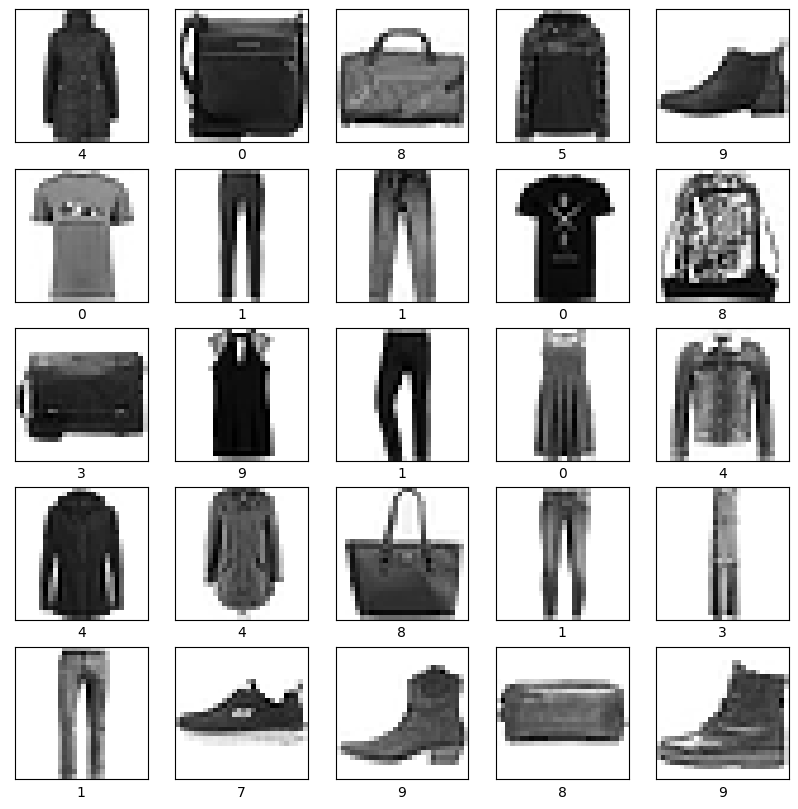

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_trn[i], cmap=plt.cm.binary)
    plt.xlabel(y_trn[i])
plt.show()

Looks like fashion! Let's also check what the class labels might represent. The following code plots the first 10 instances of class `9`.

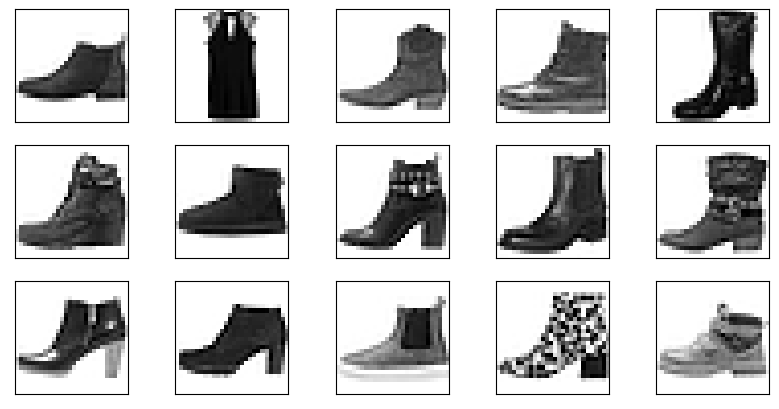

In [4]:
X_9 = X_trn[y_trn == 9] # select all instances of class 9

plt.figure(figsize=(10,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_9[i], cmap=plt.cm.binary)
plt.show()

Most of these examples are boots!

It is now your goal to find out, which training examples are best suited to train a machine learning model that performs well on the testing data `(X_tst, y_tst)`, without knowing `y_tst`.

Good luck!

In [5]:
# proceed with any code you like